In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import os.path
import tensorflow as tf
import tensorflow_addons as tfa
import PIL
import PIL.Image
from random import randint
from pickle import dump, load

In [3]:
def get_dataset_partitions_tf(ds, ds_size, train_split=0.7, val_split=0.2, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)


    return train_ds, val_ds, test_ds

def random_brightness(image):
    return tf.image.random_brightness(image, max_delta=0.2)

def build_metrics(no_of_classes):
    metrics = []
    metrics.append('accuracy')
    for i in range(0, no_of_classes):
        metric_name = '{}{}'.format('precision', i)
        metrics.append(tf.keras.metrics.Precision(class_id=i, name=metric_name))

    for i in range(0, no_of_classes):
        metric_name = '{}{}'.format('recall', i)
        metrics.append(tf.keras.metrics.Recall(class_id=i, name=metric_name))

    metrics.append(tf.keras.metrics.AUC(curve='ROC', name='roc_auc', multi_label=True, num_labels=no_of_classes))
    metrics.append(tfa.metrics.MultiLabelConfusionMatrix(num_classes=no_of_classes))
    return metrics

def get_precision_evaluation(history):
    precision = 0.0
    precision_begin = 2
    precision_end = precision_begin + num_classes
    for i in range(precision_begin, precision_end):
        precision += history[i]

    return precision / num_classes

def get_recall_evaluation(history):
    recall = 0.0
    recall_begin = 2 + num_classes
    recall_end = recall_begin + num_classes
    for i in range(recall_begin, recall_end):
        recall += history[i]

    return recall / num_classes

def get_f1_score(precision, recall):
    f1_score = 0.0
    if (precision + recall) != 0:
        f1_score = (2 * precision * recall) / (precision + recall)

    return f1_score

def get_precision_histories(history):
    precision_history = [0] * initial_epochs
    val_precision_history = [0] * initial_epochs
    for i in range(0, num_classes):
        metric_name = '{}{}'.format('precision', i)
        val_metric_name = 'val_' + metric_name
        precision_history = [sum(x) for x in zip(precision_history, history[metric_name])]
        val_precision_history = [sum(x) for x in zip(precision_history, history[val_metric_name])]

    for i in range(0, initial_epochs):
        precision_history[i] = precision_history[i] / num_classes
        val_precision_history[i] = val_precision_history[i] / num_classes

    return precision_history, val_precision_history

def get_recall_histories(history):
    recall_history = [0] * initial_epochs
    val_recall_history = [0] * initial_epochs
    for i in range(0, num_classes):
        metric_name = '{}{}'.format('recall', i)
        val_metric_name = 'val_' + metric_name
        recall_history = [sum(x) for x in zip(recall_history, history[metric_name])]
        val_recall_history = [sum(x) for x in zip(recall_history, history[val_metric_name])]

    for i in range(0, initial_epochs):
        recall_history[i] = recall_history[i] / num_classes
        val_recall_history[i] = val_recall_history[i] / num_classes

    return recall_history, val_recall_history

def calculate_f1_scores(precision, recall, val_precision, val_recall):
    f1_score_temp = np.empty(len(precision))
    val_f1_score_temp = np.empty(len(f1_score_temp))
    for i in range(len(precision)):
        harmonic_avg = 0.0
        if (precision[i] + recall[i]) != 0:
            harmonic_avg = (2 * precision[i] * recall[i]) / (precision[i] + recall[i])

        val_harmonic_avg = 0.0
        if (val_precision[i] + val_recall [i]) != 0:
            val_harmonic_avg = (2 * val_precision[i] * val_recall [i]) / (val_precision[i] + val_recall [i])

        np.put(f1_score_temp, i, harmonic_avg)
        np.put(val_f1_score_temp, i, val_harmonic_avg)
    return [f1_score_temp, val_f1_score_temp]

def combine_2_histories(history1, history2):
    combined_history = {}
    for key in history1.history.keys():
        combined_history[key] = history1.history[key] + history2.history[key]
    return combined_history

def combine_multiple_histories(histories):
    combined_history = {}
    for history in histories:
        for key, value in history.items():
            if key not in combined_history:
                combined_history[key] = value.copy()
            else:
                combined_history[key].extend(value.copy())
    return combined_history

In [4]:
PATH = "D:\y3\licenta_shit\CCSN_v2"
file_types = ('*.jpg', '*.jpeg', '*.png')

BATCH_SIZE = 32
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)

dataset = tf.keras.preprocessing.image_dataset_from_directory(PATH,
                                      shuffle=True,
                                      label_mode='categorical',
                                      batch_size=BATCH_SIZE,
                                      image_size=IMG_SIZE)

class_names = dataset.class_names
num_classes = len(class_names)
print(num_classes)
print(class_names)

train_dataset, validation_dataset, test_dataset = get_dataset_partitions_tf(dataset, ds_size=len(dataset))

print('Size of training dataset batch: %d' % len(train_dataset))
print('Size of validation dataset batch: %d' % len(validation_dataset))
print('Size of test dataset batch: %d' % len(test_dataset))

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation((-0.2,0.3)),
    tf.keras.layers.RandomContrast(0.2, 0.5),
    tf.keras.layers.Lambda(random_brightness),
    tf.keras.layers.GaussianNoise(0.1)
])

base_model = tf.keras.applications.EfficientNetV2B0(input_shape=IMG_SHAPE, include_top=False, weights=None)

image_batch, label_batch = train_dataset.as_numpy_iterator().next()
feature_batch = base_model(image_batch)

base_model.trainable = True

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
prediction_layer = tf.keras.layers.Dense(num_classes, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)

inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = base_model(x)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

Found 2543 files belonging to 11 classes.
11
['Ac', 'As', 'Cb', 'Cc', 'Ci', 'Cs', 'Ct', 'Cu', 'Ns', 'Sc', 'St']
Size of training dataset batch: 56
Size of validation dataset batch: 16
Size of test dataset batch: 8




In [5]:
metrics = build_metrics(num_classes)
base_learning_rate = 0.00001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=metrics)

In [6]:
model.load_weights('D:/y3/licenta_shit/new_experiments/efficientnetv2b0/cce_32_0_00001/weights/epochs_500')

In [7]:
with open('D:/y3/licenta_shit/new_experiments/efficientnetv2b0/cce_32_0_00001/history/epochs_500.json', 'rb') as file:
    history = load(file)

In [8]:
len(history['loss'])

500

In [9]:
initial_epochs = 500
acc = history['accuracy']
val_acc = history['val_' + 'accuracy']

loss = history['loss']
val_loss = history['val_' + 'loss']

roc_auc = history['roc_auc']
val_roc_auc = history['val_roc_auc']

precision, val_precision = get_precision_histories(history)

recall, val_recall = get_recall_histories(history)

f1_score, val_f1_score = calculate_f1_scores(precision, recall, val_precision, val_recall)

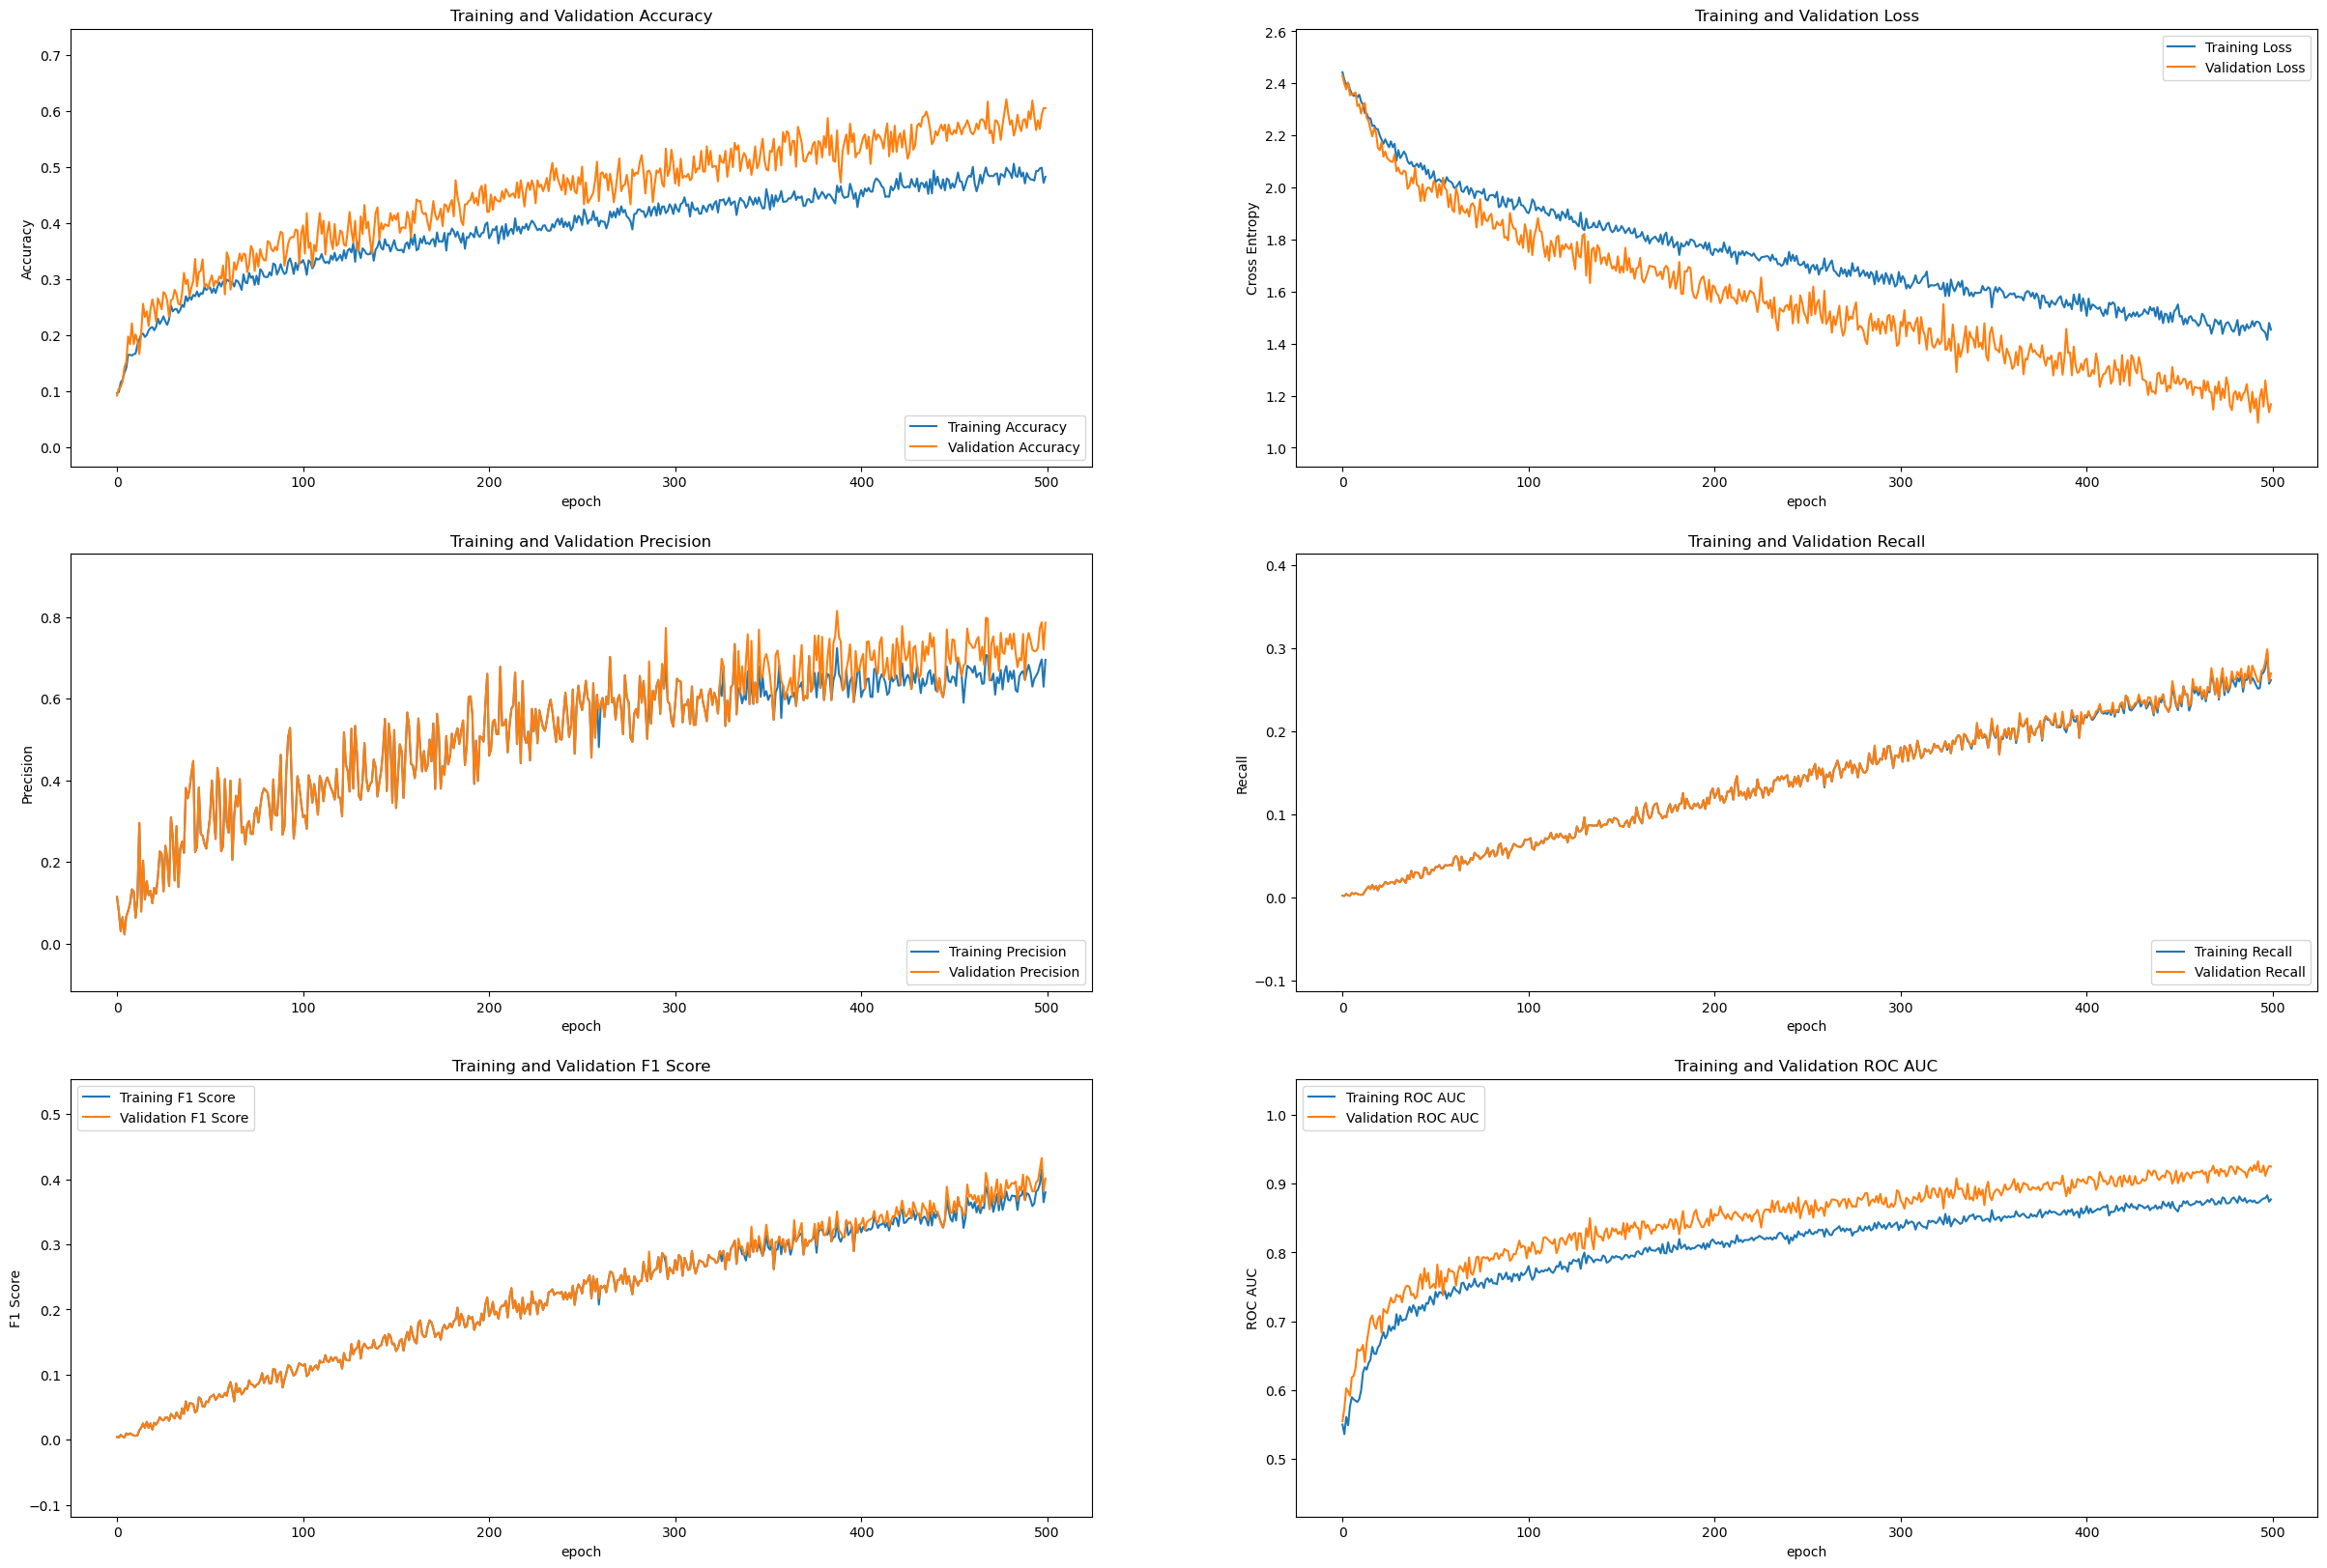

In [10]:
plt.figure(figsize=(30, 20))

plt.subplot(3, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()) - 0.1, max(plt.ylim()) + 0.1])
plt.title('Training and Validation Accuracy')
plt.xlabel('epoch')

plt.subplot(3, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([min(plt.ylim()) - 0.1, max(plt.ylim()) + 0.1])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.subplot(3, 2, 3)
plt.plot(precision, label='Training Precision')
plt.plot(val_precision, label='Validation Precision')
plt.legend(loc='lower right')
plt.ylabel('Precision')
plt.ylim([min(plt.ylim()) - 0.1, max(plt.ylim()) + 0.1])
plt.title('Training and Validation Precision')
plt.xlabel('epoch')

plt.subplot(3, 2, 4)
plt.plot(recall, label='Training Recall')
plt.plot(val_recall, label='Validation Recall')
plt.legend(loc='lower right')
plt.ylabel('Recall')
plt.ylim([min(plt.ylim()) - 0.1, max(plt.ylim()) + 0.1])
plt.title('Training and Validation Recall')
plt.xlabel('epoch')

plt.subplot(3, 2, 5)
plt.plot(f1_score, label='Training F1 Score')
plt.plot(val_f1_score, label='Validation F1 Score')
plt.legend(loc='upper left')
plt.ylabel('F1 Score')
plt.ylim([min(plt.ylim()) - 0.1, max(plt.ylim()) + 0.1])
plt.title('Training and Validation F1 Score')
plt.xlabel('epoch')

plt.subplot(3, 2, 6)
plt.plot(roc_auc, label='Training ROC AUC')
plt.plot(val_roc_auc, label='Validation ROC AUC')
plt.legend(loc='upper left')
plt.ylabel('ROC AUC')
plt.ylim([min(plt.ylim()) - 0.1, max(plt.ylim()) + 0.1])
plt.title('Training and Validation ROC AUC')
plt.xlabel('epoch')

plt.show()

In [13]:
test_results = model.evaluate(test_dataset)

test_precision = get_precision_evaluation(test_results)
test_recall = get_recall_evaluation(test_results)
test_f1_score = get_f1_score(test_precision, test_recall)
test_roc_auc_index = 2 + (2 * num_classes)

print("Test loss: {}".format(test_results[0]))
print("Test accuracy: {}".format(test_results[1]))
print("Test precision: {}".format(test_precision))
print("Test recall: {}".format(test_recall))
print("Test F1 score: {}".format(test_f1_score))
print("Test ROC: {}".format(test_results[test_roc_auc_index]))

8/8 [==============================] - 16s 1s/step - loss: 1.1127 - accuracy: 0.6055 - precision0: 1.0000 - precision1: 1.0000 - precision2: 0.8000 - precision3: 0.7778 - precision4: 1.0000 - precision5: 0.7143 - precision6: 0.9444 - precision7: 0.9091 - precision8: 0.7391 - precision9: 0.7931 - precision10: 1.0000 - recall0: 0.2353 - recall1: 0.4828 - recall2: 0.5217 - recall3: 0.3500 - recall4: 0.0667 - recall5: 0.1852 - recall6: 0.9444 - recall7: 0.3704 - recall8: 0.6800 - recall9: 0.5610 - recall10: 0.1429 - roc_auc: 0.9290 - Multilabel_confusion_matrix: 64.0000              
Test loss: 1.1126556396484375
Test accuracy: 0.60546875
Test precision: 0.8798029802062295
Test recall: 0.4127537493001331
Test F1 score: 0.5618971615493251
Test ROC: 0.9290239214897156


In [14]:
model450 = tf.keras.Model(inputs, outputs)
base_learning_rate = 0.0001
model450.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=metrics)
model450.load_weights('D:/y3/licenta_shit/new_experiments/efficientnetv2b0/cce_32_0_00001/weights/epochs_450')
with open('D:/y3/licenta_shit/new_experiments/efficientnetv2b0/cce_32_0_00001/history/epochs_450.json', 'rb') as file:
    history450 = load(file)

In [15]:
test_results = model450.evaluate(test_dataset)

test_precision = get_precision_evaluation(test_results)
test_recall = get_recall_evaluation(test_results)
test_f1_score = get_f1_score(test_precision, test_recall)
test_roc_auc_index = 2 + (2 * num_classes)

print("Test loss: {}".format(test_results[0]))
print("Test accuracy: {}".format(test_results[1]))
print("Test precision: {}".format(test_precision))
print("Test recall: {}".format(test_recall))
print("Test F1 score: {}".format(test_f1_score))
print("Test ROC: {}".format(test_results[test_roc_auc_index]))

8/8 [==============================] - 40s 1s/step - loss: 1.2597 - accuracy: 0.5703 - precision0: 0.8889 - precision1: 1.0000 - precision2: 0.7632 - precision3: 0.6154 - precision4: 0.5000 - precision5: 0.5833 - precision6: 0.8649 - precision7: 0.7778 - precision8: 0.7500 - precision9: 0.7167 - precision10: 0.8000 - recall0: 0.1538 - recall1: 0.3542 - recall2: 0.6042 - recall3: 0.3902 - recall4: 0.0800 - recall5: 0.1346 - recall6: 0.9143 - recall7: 0.3043 - recall8: 0.5660 - recall9: 0.5584 - recall10: 0.1143 - roc_auc: 0.9185 - Multilabel_confusion_matrix: 128.0000
Test loss: 1.2596654891967773
Test accuracy: 0.5703125
Test precision: 0.7509158253669739
Test recall: 0.3794943019747734
Test F1 score: 0.5041856404092504
Test ROC: 0.9185433983802795


In [16]:
initial_epochs = 450
acc = history450['accuracy']
val_acc = history450['val_' + 'accuracy']

loss = history450['loss']
val_loss = history450['val_' + 'loss']

roc_auc = history450['roc_auc']
val_roc_auc = history450['val_roc_auc']

precision, val_precision = get_precision_histories(history450)

recall, val_recall = get_recall_histories(history450)

f1_score, val_f1_score = calculate_f1_scores(precision, recall, val_precision, val_recall)

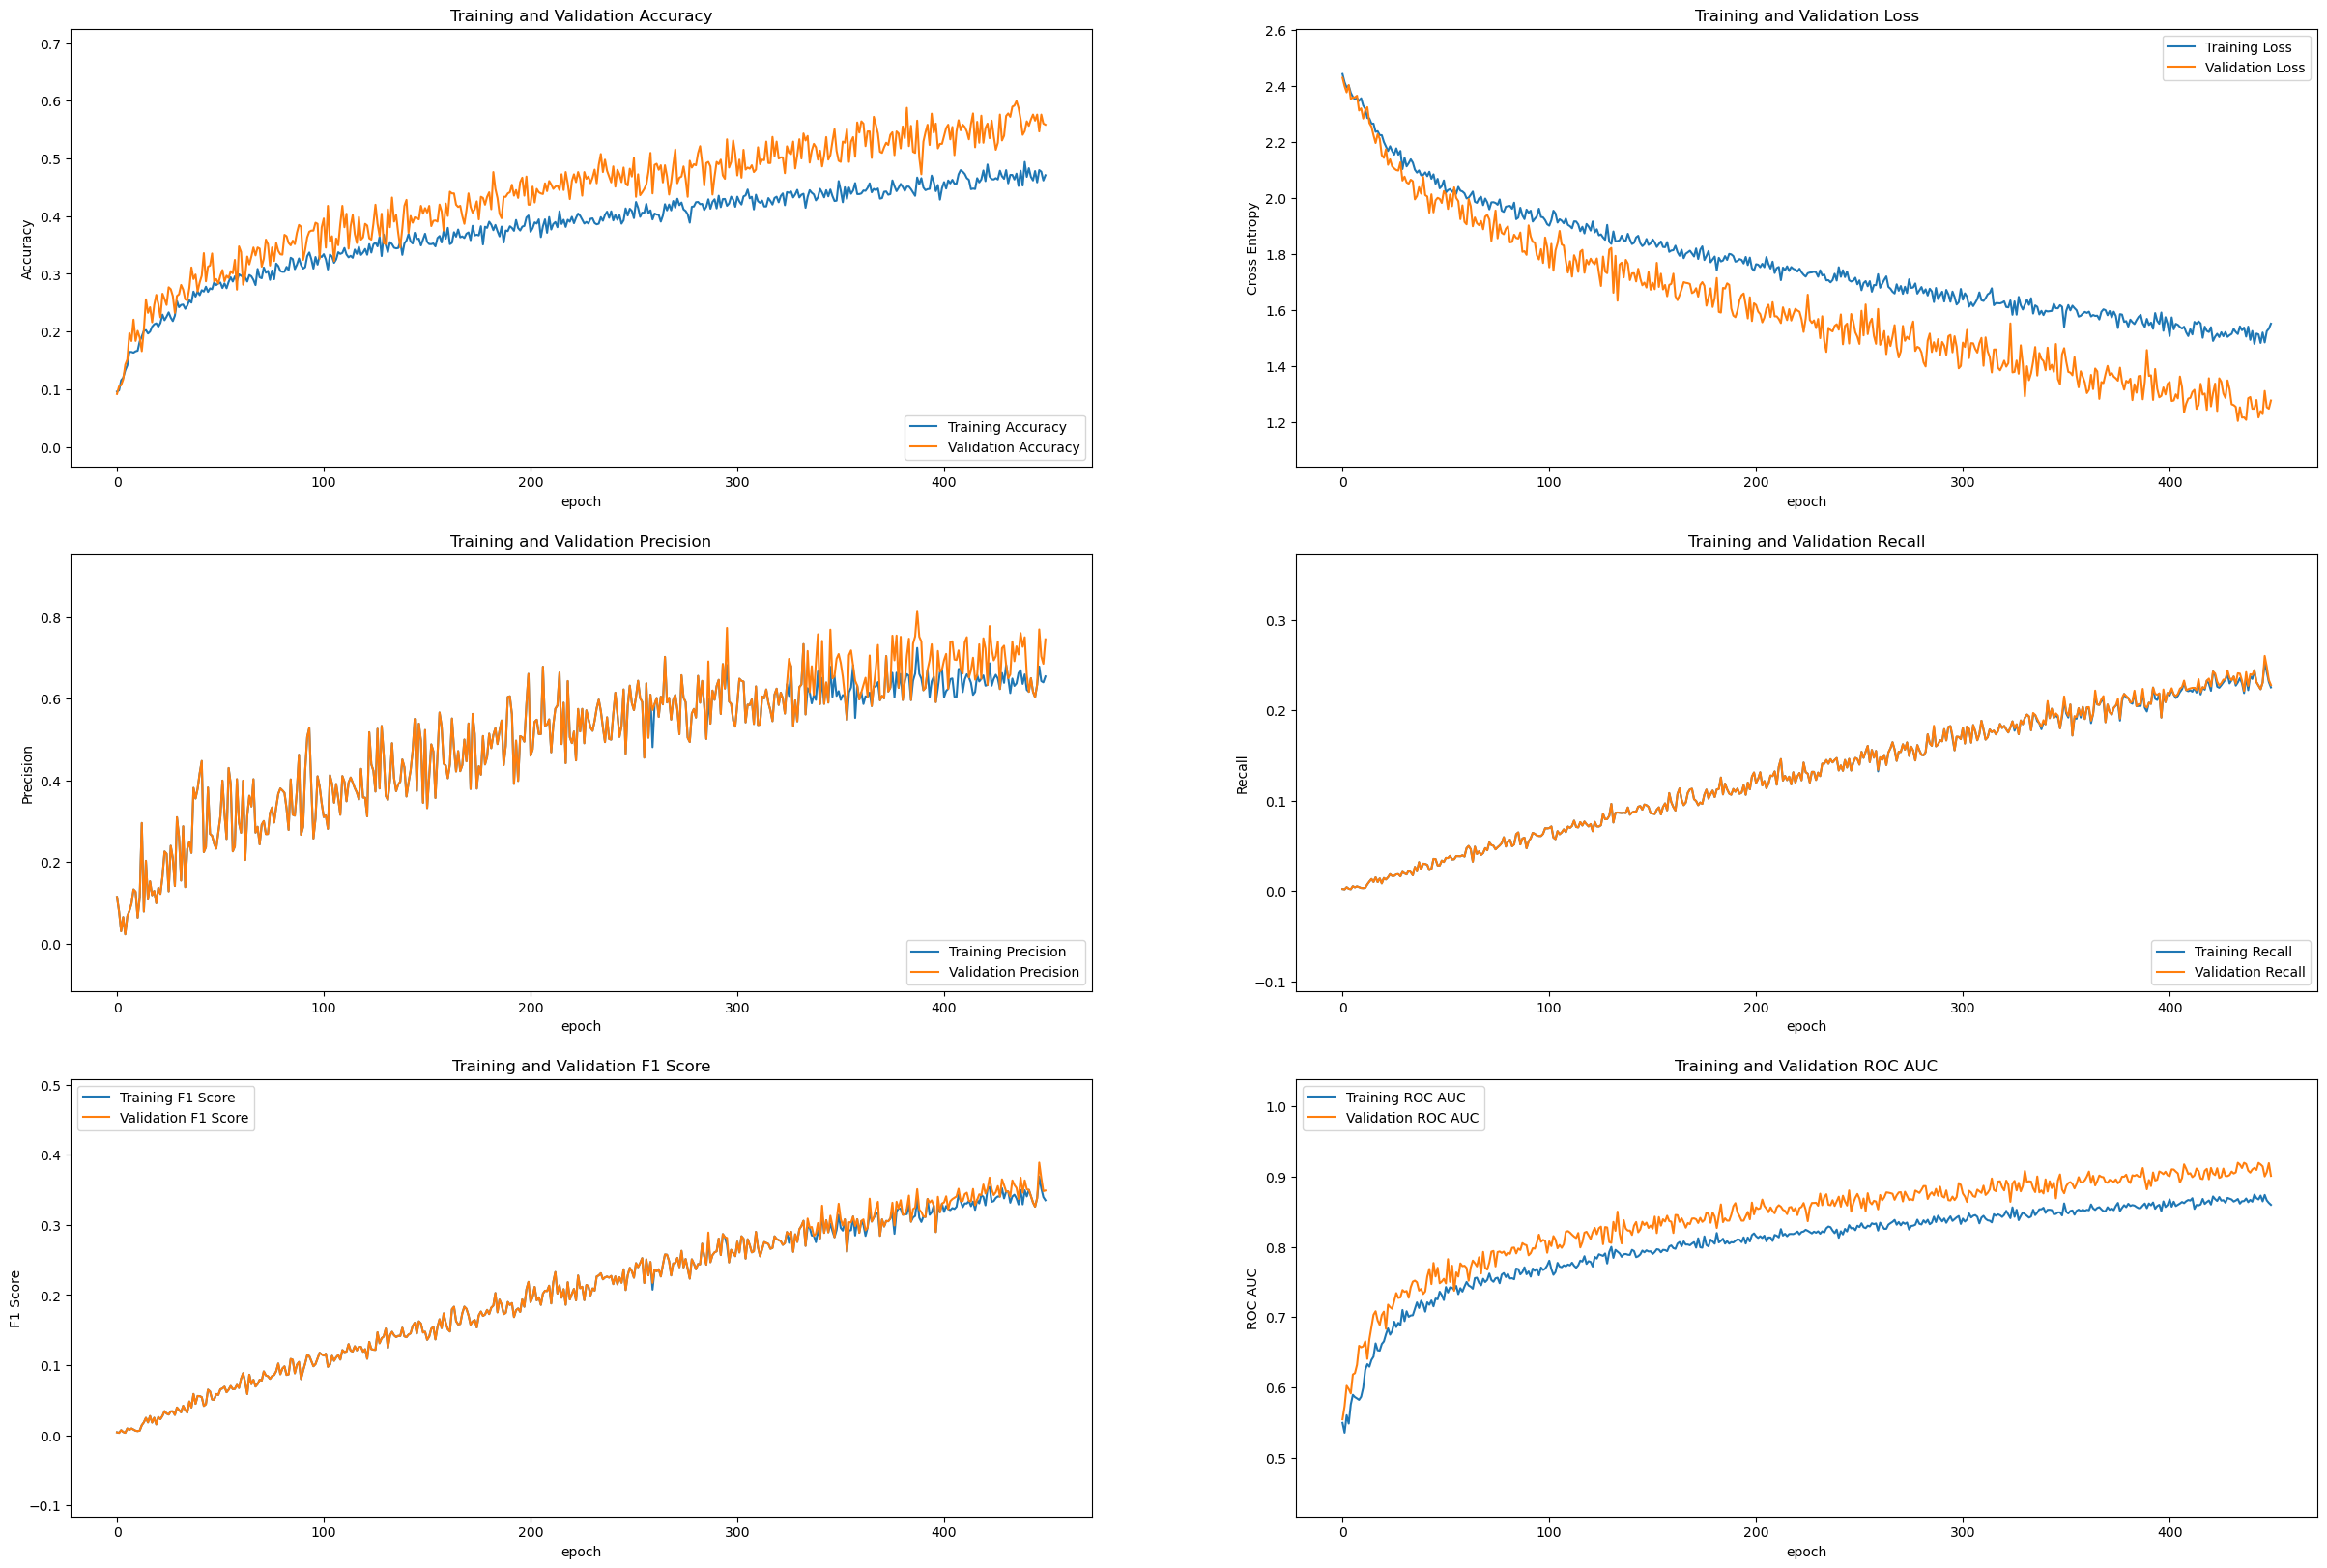

In [17]:
plt.figure(figsize=(30, 20))

plt.subplot(3, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()) - 0.1, max(plt.ylim()) + 0.1])
plt.title('Training and Validation Accuracy')
plt.xlabel('epoch')

plt.subplot(3, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([min(plt.ylim()) - 0.1, max(plt.ylim()) + 0.1])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.subplot(3, 2, 3)
plt.plot(precision, label='Training Precision')
plt.plot(val_precision, label='Validation Precision')
plt.legend(loc='lower right')
plt.ylabel('Precision')
plt.ylim([min(plt.ylim()) - 0.1, max(plt.ylim()) + 0.1])
plt.title('Training and Validation Precision')
plt.xlabel('epoch')

plt.subplot(3, 2, 4)
plt.plot(recall, label='Training Recall')
plt.plot(val_recall, label='Validation Recall')
plt.legend(loc='lower right')
plt.ylabel('Recall')
plt.ylim([min(plt.ylim()) - 0.1, max(plt.ylim()) + 0.1])
plt.title('Training and Validation Recall')
plt.xlabel('epoch')

plt.subplot(3, 2, 5)
plt.plot(f1_score, label='Training F1 Score')
plt.plot(val_f1_score, label='Validation F1 Score')
plt.legend(loc='upper left')
plt.ylabel('F1 Score')
plt.ylim([min(plt.ylim()) - 0.1, max(plt.ylim()) + 0.1])
plt.title('Training and Validation F1 Score')
plt.xlabel('epoch')

plt.subplot(3, 2, 6)
plt.plot(roc_auc, label='Training ROC AUC')
plt.plot(val_roc_auc, label='Validation ROC AUC')
plt.legend(loc='upper left')
plt.ylabel('ROC AUC')
plt.ylim([min(plt.ylim()) - 0.1, max(plt.ylim()) + 0.1])
plt.title('Training and Validation ROC AUC')
plt.xlabel('epoch')

plt.show()

In [18]:
images_test = []
labels_test = []

for batch in test_dataset:
    image_batch, label_batch = batch
    for i in image_batch:
        images_test.append(i)

    for i in label_batch:
        labels_test.append(i)

images_test = np.array(images_test)
labels_test = np.array(labels_test)
predictions = model450.predict_on_batch(images_test)

In [19]:
def get_highest_label(label_arr):
    max_num = -1
    max_index = -1
    for i in range(0, num_classes):
        if label_arr[i] > max_num:
            max_num = label_arr[i]
            max_index = i

    return max_index

In [20]:
labelMapFunc = lambda x: get_highest_label(x)
labels_test_single = np.array([labelMapFunc(xi) for xi in labels_test])
predictions_test_single = np.array([labelMapFunc(xi) for xi in predictions])

In [21]:
labels_test_single

array([ 9,  8,  0,  8,  6, 10,  9,  3,  5,  9,  2,  3,  5,  1,  0,  9,  8,
        8,  8,  8,  2,  8,  5,  1,  2,  6,  9,  1,  9, 10,  8,  8,  7,  6,
        6,  9,  0,  5,  3,  8,  3,  6,  0,  5,  6,  1, 10,  9,  7,  9,  3,
        6,  9,  4,  6,  8, 10,  9,  8,  4,  2,  5,  2,  7,  9,  3,  4,  5,
        2,  2,  6,  5,  2,  6,  3,  0,  5,  5,  8,  5,  2,  4,  3,  5,  8,
        4,  0,  5,  0,  9,  8,  6,  1,  1,  0,  3,  5,  2,  3,  3,  0,  2,
        9,  5,  5,  9,  3,  0,  5,  3,  9, 10,  9,  3,  2,  8,  8,  3,  5,
        8,  9,  7,  8, 10,  8,  8,  8,  4,  3,  2,  3,  0,  5,  1,  4,  4,
        8,  0,  0,  9,  5,  5, 10,  6,  1,  8,  9,  5,  5,  8,  5,  8,  3,
        0,  5,  2, 10,  0, 10,  9,  3,  3,  1,  5,  5,  2,  4,  2,  8,  5,
        8,  3,  2,  4,  9,  8, 10,  2,  9,  8,  9,  0,  3,  2,  2,  6,  1,
        0,  1,  9,  5, 10,  0,  9,  7, 10,  2,  3,  1,  5,  3,  9,  0,  9,
        9,  2,  9,  4,  6,  8,  5,  9, 10,  9,  0,  1,  0,  7,  6,  9,  5,
       10,  2,  7,  3,  0

In [22]:
predictions_test_single

array([ 9,  9,  2,  8,  6,  3,  9,  0,  5,  9,  2,  4,  5,  2,  9,  9,  8,
        8,  2,  9,  2,  8,  5,  2,  2,  8,  9,  0,  7,  9,  3,  3,  2,  4,
        6,  9,  8,  4,  6,  9,  3,  6,  5,  8,  3,  1,  5,  9,  2,  9,  3,
        6,  9,  3,  6,  0, 10,  9,  8,  0,  2,  5,  2,  2,  9,  3,  8,  3,
        2,  2,  6,  9,  2,  6,  3,  0,  5,  8,  8,  9,  2,  9,  6,  8,  8,
        4,  7,  5,  3,  9,  8,  6,  8,  1,  0,  0,  8,  2,  7,  3,  0,  2,
        9,  6,  5,  9,  3,  1,  5,  3,  5,  9,  9,  0,  2,  8,  8,  3,  9,
        1,  9,  2,  8, 10,  8,  8, 10,  9,  3,  2,  3,  3,  7,  3,  3,  1,
        6,  9,  2,  9,  5,  5,  9,  6,  8,  8,  9,  9,  9,  8,  5,  8,  3,
        0,  5,  2,  9,  3,  8,  9,  0,  3,  4,  1,  6,  8,  3,  2,  8,  4,
        9,  3,  2,  4,  9,  8,  9,  2,  9,  8,  9,  3,  6,  2,  2,  6,  1,
        7,  0,  9,  9,  8,  6,  2,  3,  3,  2,  3, 10,  5,  8,  8,  8,  9,
        9,  2,  9,  3,  6,  8,  8,  9,  5,  9,  5,  8,  3,  7,  6,  2,  3,
        7,  2,  7,  3,  8

In [23]:
multi_class_confusion_matrix = []
for i in range(0, num_classes):
    row = [0] * num_classes
    multi_class_confusion_matrix.append(row)

for i in range(0, len(labels_test_single)):
    actual = labels_test_single[i]
    pred = predictions_test_single[i]

    multi_class_confusion_matrix[actual][pred] = multi_class_confusion_matrix[actual][pred] + 1

multi_class_confusion_matrix

[[4, 1, 3, 5, 0, 2, 1, 2, 3, 2, 0],
 [2, 5, 2, 1, 1, 0, 0, 0, 4, 0, 1],
 [0, 0, 26, 0, 0, 0, 0, 0, 1, 0, 0],
 [4, 0, 0, 16, 1, 1, 3, 3, 1, 0, 0],
 [1, 1, 0, 4, 3, 0, 0, 0, 1, 2, 0],
 [1, 2, 0, 3, 2, 15, 2, 1, 5, 6, 0],
 [0, 0, 0, 1, 1, 0, 13, 0, 1, 0, 0],
 [0, 0, 5, 1, 0, 0, 0, 3, 0, 0, 0],
 [1, 1, 1, 2, 0, 1, 1, 0, 21, 5, 1],
 [0, 1, 2, 0, 0, 1, 0, 1, 1, 31, 0],
 [0, 0, 1, 2, 0, 2, 0, 1, 2, 6, 2]]

In [24]:
def print_matrix(matrix):
    s = ''
    for i in range(0, len(matrix)):
        for j in range(0, len(matrix[0])):
            s = s + '\t' + str(matrix[i][j])
        s = s + '\n'

    print(s)

In [25]:
print_matrix(multi_class_confusion_matrix)

	4	1	3	5	0	2	1	2	3	2	0
	2	5	2	1	1	0	0	0	4	0	1
	0	0	26	0	0	0	0	0	1	0	0
	4	0	0	16	1	1	3	3	1	0	0
	1	1	0	4	3	0	0	0	1	2	0
	1	2	0	3	2	15	2	1	5	6	0
	0	0	0	1	1	0	13	0	1	0	0
	0	0	5	1	0	0	0	3	0	0	0
	1	1	1	2	0	1	1	0	21	5	1
	0	1	2	0	0	1	0	1	1	31	0
	0	0	1	2	0	2	0	1	2	6	2



In [26]:
print('test size: ', len(test_dataset))

image_batch, label_batch = test_dataset.as_numpy_iterator().next()
print('image_batch size: ', len(image_batch))
print('label_batch size: ', len(label_batch))
print('label_batch example: ', label_batch[0])

predictions = model450.predict_on_batch(image_batch)
print('predictions size: ', len(predictions))
print('predictions example: ', predictions[0])

test size:  8
image_batch size:  32
label_batch size:  32
label_batch example:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
predictions size:  32
predictions example:  [1.1169256e-03 2.1365460e-03 7.3668235e-03 2.3921570e-04 1.1832330e-03
 1.6227499e-02 6.0549395e-05 5.9159277e-03 8.1274800e-02 8.2484502e-01
 5.9633512e-02]


In [27]:
def plot_image(i, predictions_array, true_label, img):
    img = img[i]
    true_label = true_label[i]
    true_label = np.argmax(true_label)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img.astype("uint8"))

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    true_label = true_label[i]
    true_label = np.argmax(true_label)
    plt.grid(False)
    plt.xticks(range(num_classes), class_names)
    plt.yticks([])
    thisplot = plt.bar(range(num_classes), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

In [28]:
def generate_random_indices(max_number, size):
    result = []
    random_number = randint(0, max_number - 1)
    while len(result) < size:
        while random_number in result:
            random_number = randint(0, max_number - 1)

        result.append(random_number)

    return result

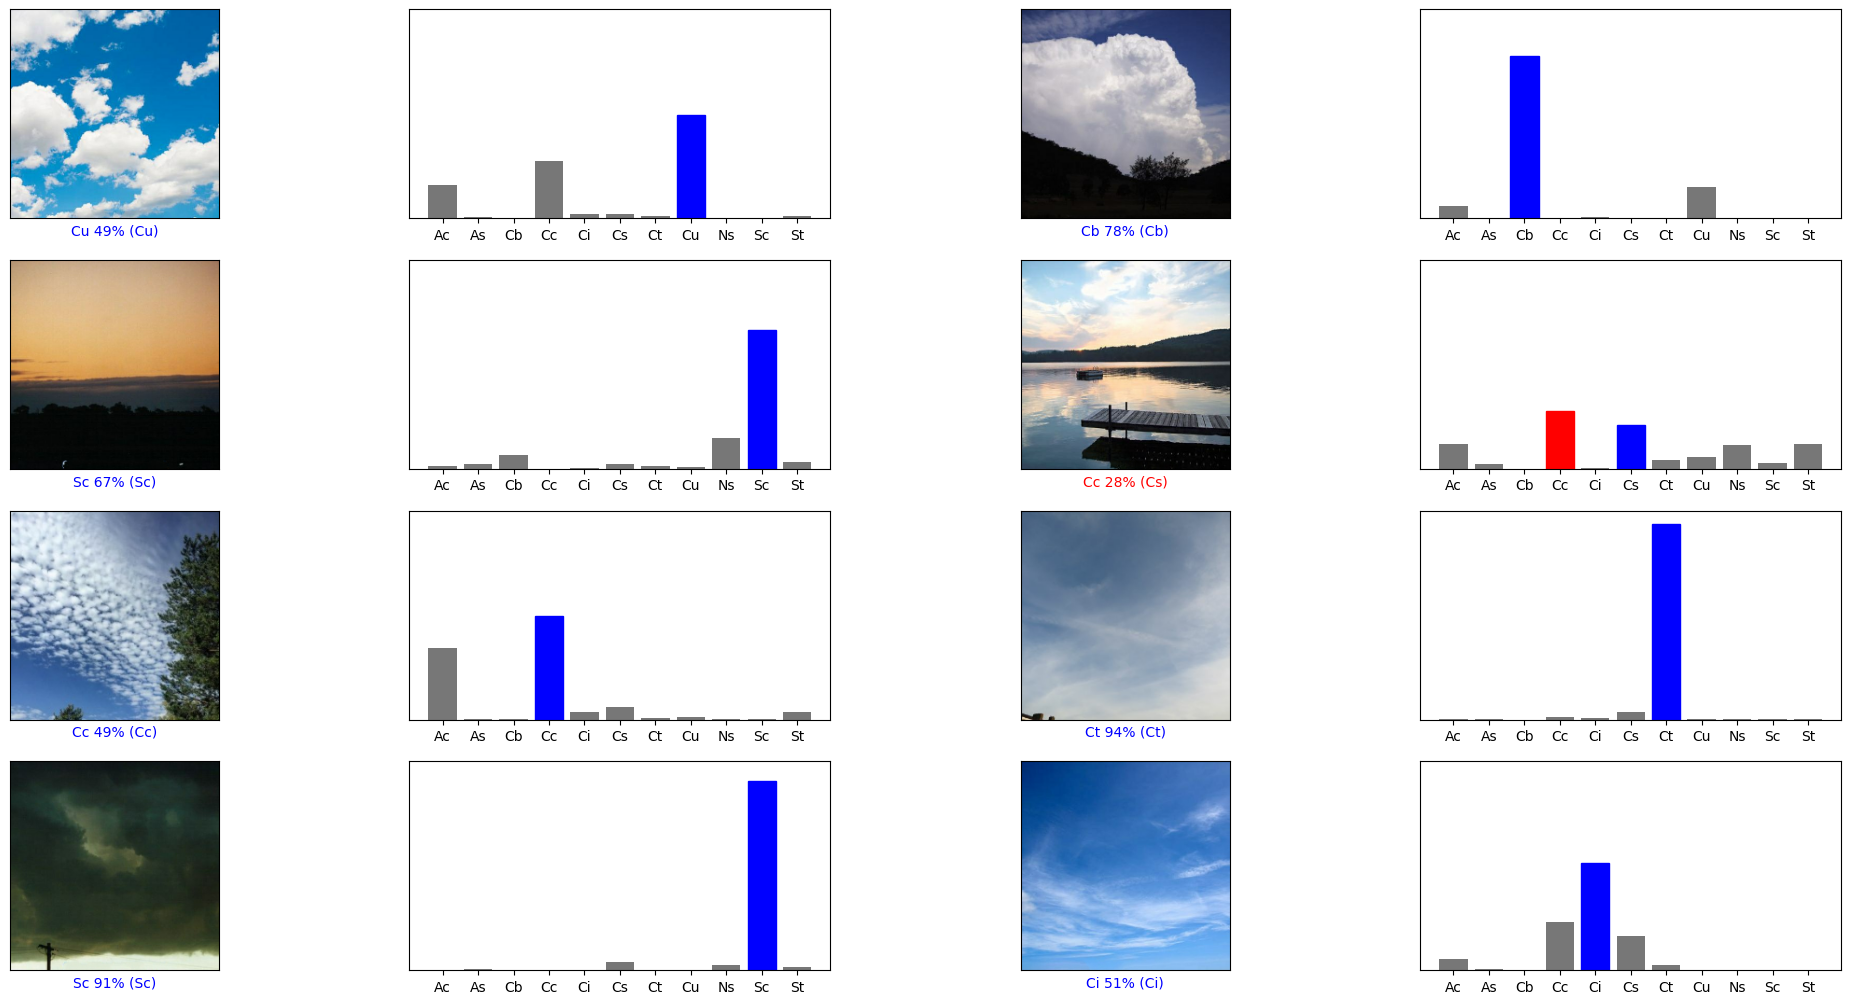

In [29]:
row_count = 4
col_count = 2
img_view_size = row_count * col_count

indices = generate_random_indices(len(image_batch), img_view_size)

plt.figure(figsize=(12.5 * col_count, 3.12 * row_count))
for j in range(0, img_view_size):
    i = indices[j]

    #display image
    plt.subplot(row_count, 2 * col_count, 2 * j + 1)
    plot_image(i, predictions[i], label_batch, image_batch)

    #display prediction bar graph
    plt.subplot(row_count, 2 * col_count, (2 * j) + 2)
    plot_value_array(i, predictions[i],  label_batch)

plt.show()